In [ ]:
# ===== emotion_pipeline =====

# Imports
import numpy as np
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score

from config import Config
from utils.load_npz import load_dataset
from utils.preprocess import preprocess_batch
from utils.features import extract_features
from models.multimodal_model import MultiModalNet

In [ ]:
# Task/ckpt
TASK = 'emotion'
CKPT = 'best_emotion_model.pth'
print('TASK =', TASK, '| CKPT =', CKPT)

# Load .npz
dataset = load_dataset(task_type=TASK)
fs = int(dataset['sampling_rate'])
n_channels = int(dataset['X_train'].shape[1])

if 'class_names' in dataset:
    class_names = list(dataset['class_names'])
elif 'label_map' in dataset:
    class_names = list(dataset['label_map'].keys())
else:
    class_names = sorted(list(np.unique(dataset['y_train'])))
n_classes = len(class_names)
print('fs:', fs, '| channels:', n_channels, '| classes:', n_classes, class_names)

TASK = intent | CKPT = best_intent_model.pth
[2025-08-27 10:20:22] Loading dataset from d:\Projects\emo_bci\data\intent_dataset_20250826_201559.npz
  -> Dataset loaded successfully
  -> Task: intent_detection
  -> Channels: ['F7', 'FT7', 'T7', 'F8', 'FT8', 'T8']
  -> Sampling rate: 250 Hz
  -> Trial duration: 10.0 s
  -> Train: 72 samples
  -> Val: 16 samples
  -> Test: 12 samples
  -> Data shape: (72, 6, 2500)
fs: 250 | channels: 6 | classes: 4 [np.str_('baseline'), np.str_('jaw_clench'), np.str_('gaze_left'), np.str_('gaze_right')]


In [5]:
# Preprocess (notch + band-pass + z-score)
NOTCH_F0, NOTCH_Q = 50.0, 25.0
BAND = (1.0, 40.0)
ORDER = 4
X_time_train = preprocess_batch(dataset['X_train'], fs, notch_freq=NOTCH_F0, notch_q=NOTCH_Q, band=BAND, order=ORDER, do_zscore=True)
X_time_val   = preprocess_batch(dataset['X_val'],   fs, notch_freq=NOTCH_F0, notch_q=NOTCH_Q, band=BAND, order=ORDER, do_zscore=True)
X_time_test  = preprocess_batch(dataset['X_test'],  fs, notch_freq=NOTCH_F0, notch_q=NOTCH_Q, band=BAND, order=ORDER, do_zscore=True)

In [ ]:
# Windowing: 2 s window, 1 s hop
WIN_SEC, HOP_SEC = 2.0, 1.0
def sliding_window(X, y, fs, win_s, hop_s):
    L = int(fs*win_s); S = int(fs*hop_s)
    Xw, Yw = [], []
    for n in range(X.shape[0]):
        T = X.shape[-1]
        if T < L: continue
        for s in range(0, T-L+1, S):
            Xw.append(X[n, :, s:s+L]); Yw.append(int(y[n]))
    return np.stack(Xw).astype(np.float32), np.array(Yw, dtype=int)

def maybe_window(X, y, fs, win_s, hop_s):
    need = int(fs*win_s)
    if X.shape[-1] == need:  # already 2 s
        return X.astype(np.float32), y.astype(int)
    if X.shape[-1] > need:   # cut long trials into 2 s with 1 s hop
        return sliding_window(X, y, fs, win_s, hop_s)
    raise ValueError(f'Window too short: need {need}, got {X.shape[-1]}')

X_time_train, y_train = maybe_window(X_time_train, dataset['y_train'], fs, WIN_SEC, HOP_SEC)
X_time_val,   y_val   = maybe_window(X_time_val,   dataset['y_val'],   fs, WIN_SEC, HOP_SEC)
X_time_test,  y_test  = maybe_window(X_time_test,  dataset['y_test'],  fs, WIN_SEC, HOP_SEC)
dataset['y_train'], dataset['y_val'], dataset['y_test'] = y_train, y_val, y_test

print('preprocessed/windowed:', X_time_train.shape, X_time_val.shape, X_time_test.shape)

# Quick sanity
assert np.isfinite(X_time_train).all() and np.isfinite(X_time_val).all() and np.isfinite(X_time_test).all()
print('sanity OK')


preprocessed/windowed: (648, 6, 500) (144, 6, 500) (108, 6, 500)
sanity OK


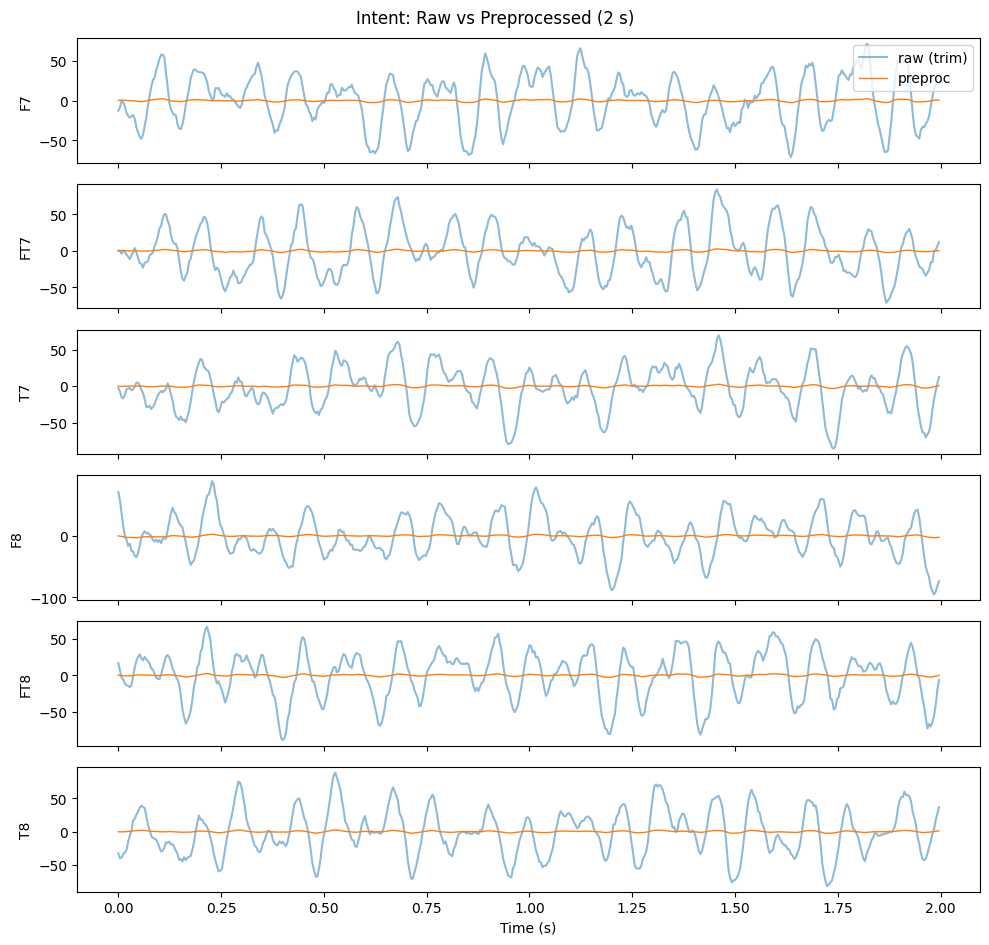

In [8]:
# Raw vs Preprocessed (trim overlay to match length)
ch_names = dataset.get('channel_names', [f'ch{i+1}' for i in range(n_channels)])
trial_idx = 0
L_pre = X_time_train.shape[-1]
t_pre = np.arange(L_pre) / fs
fig, axes = plt.subplots(nrows=n_channels, ncols=1, figsize=(10, 1.6*n_channels), sharex=True)
axes = np.atleast_1d(axes)
for c in range(n_channels):
    ax = axes[c]
    raw = dataset['X_train'][trial_idx, c]
    pre = X_time_train[trial_idx, c]
    raw_trim = raw[:L_pre]
    ax.plot(t_pre, raw_trim, alpha=0.5, label='raw (trim)')
    ax.plot(t_pre, pre, lw=1.0, label='preproc')
    ax.set_ylabel(ch_names[c])
axes[0].legend(loc='upper right')
axes[-1].set_xlabel('Time (s)')
plt.suptitle('Intent: Raw vs Preprocessed (2 s)')
plt.tight_layout(); plt.show()

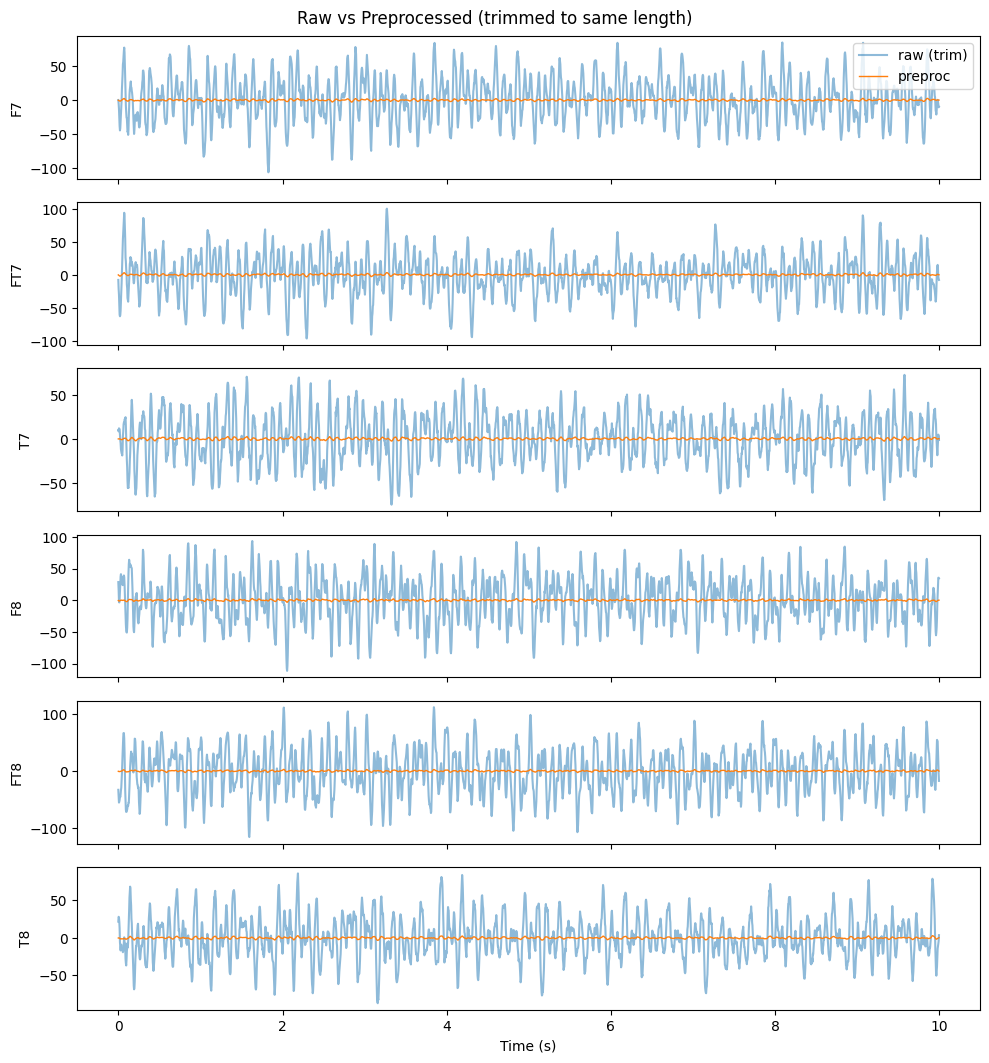

In [6]:
# Raw vs Preprocessed (trimmed overlay to match length)
import matplotlib.pyplot as plt
import numpy as np

ch_names = dataset.get('channel_names', [f'ch{i+1}' for i in range(n_channels)])
trial_idx = 0  # first trial
L_pre = X_time_train.shape[-1]        # length after windowing/preproc (e.g., 2s)
t_pre = np.arange(L_pre) / fs

fig, axes = plt.subplots(nrows=n_channels, ncols=1, figsize=(10, 1.8*n_channels), sharex=True)
axes = np.atleast_1d(axes)

for c in range(n_channels):
    ax = axes[c]
    raw = dataset['X_train'][trial_idx, c]
    pre = X_time_train[trial_idx, c]
    raw_trim = raw[:L_pre]            # trim raw to the same length as pre
    ax.plot(t_pre, raw_trim, alpha=0.5, label='raw (trim)')
    ax.plot(t_pre, pre, lw=1.0, label='preproc')
    ax.set_ylabel(ch_names[c])

axes[0].legend(loc='upper right')
axes[-1].set_xlabel('Time (s)')
plt.suptitle('Raw vs Preprocessed (trimmed to same length)')
plt.tight_layout(); plt.show()

C:\Users\gansh\AppData\Local\Temp\ipykernel_104208\668093689.py:11: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  p50_raw = np.trapz(P_raw[m50], f_raw[m50])
C:\Users\gansh\AppData\Local\Temp\ipykernel_104208\668093689.py:13: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  p50_pre = np.trapz(P_pre[m50p], f_pre[m50p])


Ch F7 50Hz raw=2.721e-01, pre=3.059e-07, red=100.0%


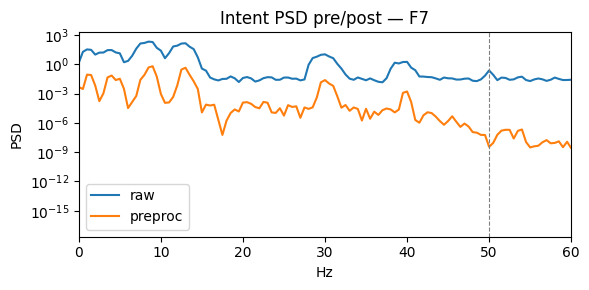

Ch F8 50Hz raw=3.084e-01, pre=4.164e-07, red=100.0%


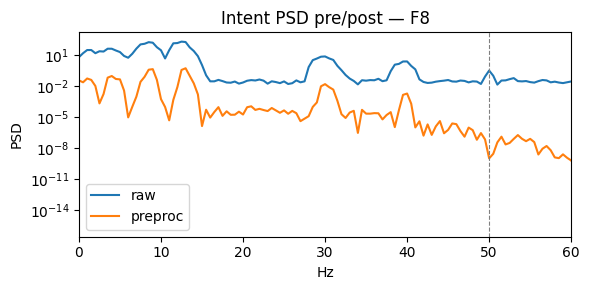

In [9]:
# PSD pre/post (example chans)
from scipy.signal import welch
def psd(x, fs, nperseg=None, noverlap=None):
    f, Pxx = welch(x, fs=fs, nperseg=nperseg, noverlap=noverlap, scaling='density'); return f, Pxx
chan_list = [0, min(3, n_channels-1)]
nper = int(fs*2.0); nov = int(fs*1.0)
for c in chan_list:
    f_raw, P_raw = psd(dataset['X_train'][trial_idx, c], fs, nper, nov)
    f_pre, P_pre = psd(X_time_train[trial_idx, c], fs, nper, nov)
    m50 = (f_raw >= 48) & (f_raw <= 52)
    p50_raw = np.trapz(P_raw[m50], f_raw[m50])
    m50p = (f_pre >= 48) & (f_pre <= 52)
    p50_pre = np.trapz(P_pre[m50p], f_pre[m50p])
    print(f'Ch {ch_names[c]} 50Hz raw={p50_raw:.3e}, pre={p50_pre:.3e}, red={(1 - p50_pre/max(p50_raw,1e-12))*100:.1f}%')
    plt.figure(figsize=(6,3))
    plt.semilogy(f_raw, P_raw, label='raw'); plt.semilogy(f_pre, P_pre, label='preproc')
    plt.axvline(50, ls='--', lw=0.8, color='grey'); plt.xlim(0, 60)
    plt.xlabel('Hz'); plt.ylabel('PSD'); plt.title(f'Intent PSD pre/post — {ch_names[c]}'); plt.legend(); plt.tight_layout(); plt.show()

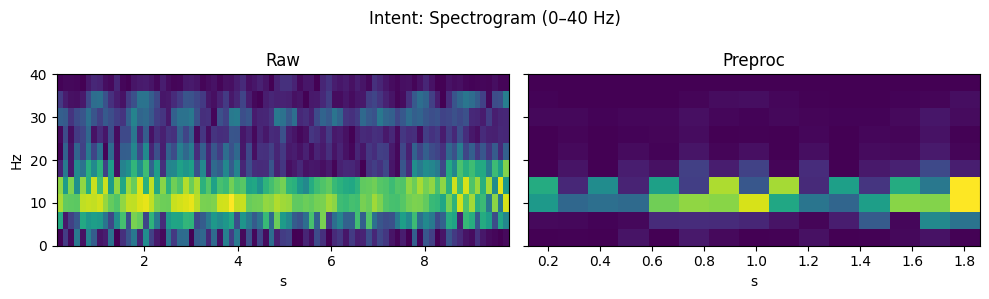

In [10]:
# Spectrogram pre/post (side-by-side, 0–40 Hz)
from scipy.signal import spectrogram
chan = 0
x0 = dataset['X_train'][trial_idx, chan]; x1 = X_time_train[trial_idx, chan]
f0, t0, S0 = spectrogram(x0, fs=fs, nperseg=int(fs*0.25), noverlap=int(fs*0.125), scaling='density', mode='psd')
f1, t1, S1 = spectrogram(x1, fs=fs, nperseg=int(fs*0.25), noverlap=int(fs*0.125), scaling='density', mode='psd')
def _norm_log(S): L=np.log1p(S); return (L - L.mean())/(L.std()+1e-8)
S0n = _norm_log(S0[f0<=40]); S1n = _norm_log(S1[f1<=40])
fig, axes = plt.subplots(1,2, figsize=(10,3), sharey=True)
axes[0].imshow(S0n, aspect='auto', origin='lower', extent=[t0[0], t0[-1], 0, 40]); axes[0].set_title('Raw'); axes[0].set_xlabel('s'); axes[0].set_ylabel('Hz')
axes[1].imshow(S1n, aspect='auto', origin='lower', extent=[t1[0], t1[-1], 0, 40]); axes[1].set_title('Preproc'); axes[1].set_xlabel('s')
plt.suptitle('Intent: Spectrogram (0–40 Hz)'); plt.tight_layout(); plt.show()

In [11]:
# Feature extraction (time + freq; images off for speed)
BANDS = ((4,8),(8,13),(13,30))
features = extract_features(
    X_time_train, X_time_val, X_time_test, fs,
    bands=BANDS,
    welch_nperseg=int(fs*0.5), welch_noverlap=int(fs*0.25),
    make_images=False,  # intent: off
    spec_nperseg=int(fs*0.25), spec_noverlap=int(fs*0.125),
    fmax=40.0, channel_method='average'
)
for k in ['X_time_train','X_freq_train','X_img_train']:
    v = features[k]; print(k, None if v is None else v.shape)

X_time_train (648, 6, 500)
X_freq_train (648, 6, 3)
X_img_train None


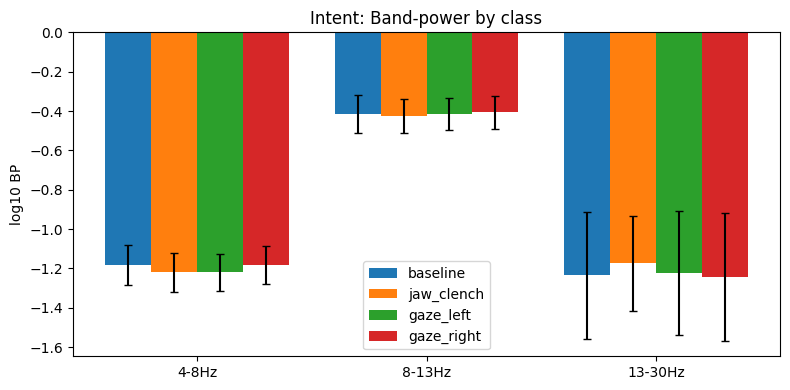

In [12]:
# Simple feature QA: band-power by class
def collapse_channels(bp): return bp.mean(axis=1)
bp_train = collapse_channels(features['X_freq_train']); y_train = dataset['y_train'].astype(int)
bands_labels = [f'{lo}-{hi}Hz' for lo,hi in BANDS]
classes = np.unique(y_train)
means = np.stack([bp_train[y_train==c].mean(axis=0) for c in classes])
stds  = np.stack([bp_train[y_train==c].std(axis=0)  for c in classes])
x = np.arange(len(bands_labels)); width = 0.8/len(classes)
plt.figure(figsize=(8,4))
for i, c in enumerate(classes):
    plt.bar(x+i*width, means[i], width=width, yerr=stds[i], capsize=3, label=str(class_names[c]))
plt.xticks(x + width*(len(classes)-1)/2, bands_labels); plt.ylabel('log10 BP')
plt.title('Intent: Band-power by class'); plt.legend(); plt.tight_layout(); plt.show()


In [13]:
# DataLoader
class EEGMultimodalDataset(Dataset):
    def __init__(self, feats, split, labels):
        self.Xt = feats[f'X_time_{split}']; self.Xf = feats[f'X_freq_{split}']; self.Xi = feats[f'X_img_{split}']
        self.y  = labels.astype(int)
    def __len__(self): return len(self.y)
    def __getitem__(self, i):
        d = {'time': torch.tensor(self.Xt[i], dtype=torch.float32),
             'freq': torch.tensor(self.Xf[i], dtype=torch.float32),
             'label': torch.tensor(int(self.y[i]), dtype=torch.long)}
        if self.Xi is not None: d['img'] = torch.tensor(self.Xi[i], dtype=torch.float32)
        return d

train_loader = DataLoader(EEGMultimodalDataset(features,'train',dataset['y_train']), batch_size=Config.batch_size, shuffle=True,  num_workers=Config.num_workers)
val_loader   = DataLoader(EEGMultimodalDataset(features,'val',  dataset['y_val']),   batch_size=Config.batch_size, shuffle=False, num_workers=Config.num_workers)
test_loader  = DataLoader(EEGMultimodalDataset(features,'test', dataset['y_test']),  batch_size=Config.batch_size, shuffle=False, num_workers=Config.num_workers)


In [14]:
# Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
use_img = features['X_img_train'] is not None
n_bands = int(features['X_freq_train'].shape[2])
n_samples = int(features['X_time_train'].shape[2])

model = MultiModalNet(
    n_channels = int(features['X_time_train'].shape[1]),
    n_samples  = n_samples,
    n_bands    = n_bands,
    img_out_dim= Config.img_out_dim,
    hidden_dim = Config.hidden_dim,
    n_classes  = n_classes,
    use_img    = use_img
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=Config.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, factor=0.5)

def run_epoch(loader, train=True):
    model.train(mode=train)
    tot=0; ok=0; loss_sum=0.0
    for b in loader:
        if train: optimizer.zero_grad()
        t = b['time'].to(device); f = b['freq'].to(device)
        i = b.get('img'); i = i.to(device) if (use_img and i is not None) else None
        y = b['label'].to(device)
        logits = model(t,f,i)
        loss = criterion(logits,y)
        if train: loss.backward(); optimizer.step()
        loss_sum += loss.item()
        ok += (logits.argmax(1)==y).sum().item()
        tot += y.size(0)
    return loss_sum/max(1,len(loader)), 100.0*ok/max(1,tot)

best_val=0.0; wait=0
hist={'train_loss':[],'val_loss':[],'train_acc':[],'val_acc':[]}
for ep in range(1, Config.num_epochs+1):
    tl, ta = run_epoch(train_loader, True)
    vl, va = run_epoch(val_loader, False)
    scheduler.step(va)
    hist['train_loss'].append(tl); hist['val_loss'].append(vl)
    hist['train_acc'].append(ta);  hist['val_acc'].append(va)
    print(f'E{ep:02d} | train {ta:5.1f}%/{tl:.4f}  val {va:5.1f}%/{vl:.4f}')
    if va > best_val:
        best_val=va; wait=0; torch.save(model.state_dict(), CKPT)
    else:
        wait += 1
        if wait >= Config.patience:
            print('Early stop.'); break

E01 | train  24.1%/1.3905  val  25.0%/1.3867
E02 | train  32.1%/1.3729  val  20.8%/1.4001
E03 | train  43.7%/1.2613  val  28.5%/1.5401
E04 | train  54.3%/1.0922  val  18.8%/1.7488
E05 | train  64.8%/0.8790  val  20.8%/2.2734
E06 | train  72.5%/0.6983  val  19.4%/2.3408
E07 | train  83.6%/0.4686  val  25.0%/2.4498
E08 | train  89.8%/0.3006  val  27.1%/2.9499
E09 | train  93.1%/0.2188  val  19.4%/3.1759
E10 | train  96.1%/0.1549  val  26.4%/3.0978
E11 | train  95.1%/0.1416  val  26.4%/3.3909
E12 | train  98.0%/0.0812  val  20.1%/3.4835
E13 | train  98.5%/0.0530  val  22.2%/3.4727
Early stop.


In [15]:
# Evaluate (val + test)
model.load_state_dict(torch.load(CKPT, map_location=device)); model.eval()

def eval_split(loader):
    yt, yp = [], []
    with torch.no_grad():
        for b in loader:
            t = b['time'].to(device); f = b['freq'].to(device)
            i = b.get('img'); i = i.to(device) if (use_img and i is not None) else None
            y = b['label'].to(device)
            pred = model(t,f,i).argmax(1)
            yt.extend(y.cpu().numpy()); yp.extend(pred.cpu().numpy())
    yt, yp = np.array(yt), np.array(yp)
    return yt, yp

yt_v, yp_v = eval_split(val_loader)
yt_t, yp_t = eval_split(test_loader)
print(f'[VAL]  acc={accuracy_score(yt_v, yp_v):.4f}  f1-macro={f1_score(yt_v, yp_v, average="macro"):.4f}')
print(classification_report(yt_v, yp_v, target_names=[str(c) for c in class_names], digits=4))
print(f'[TEST] acc={accuracy_score(yt_t, yp_t):.4f}  f1-macro={f1_score(yt_t, yp_t, average="macro"):.4f}')
print(classification_report(yt_t, yp_t, target_names=[str(c) for c in class_names], digits=4))


[VAL]  acc=0.2847  f1-macro=0.2401
              precision    recall  f1-score   support

    baseline     0.3226    0.2778    0.2985        36
  jaw_clench     0.3043    0.1944    0.2373        36
   gaze_left     0.0000    0.0000    0.0000        36
  gaze_right     0.3117    0.6667    0.4248        36

    accuracy                         0.2847       144
   macro avg     0.2347    0.2847    0.2401       144
weighted avg     0.2347    0.2847    0.2401       144

[TEST] acc=0.2778  f1-macro=0.2375
              precision    recall  f1-score   support

    baseline     0.1250    0.0741    0.0930        27
  jaw_clench     0.2273    0.1852    0.2041        27
   gaze_left     0.4000    0.1481    0.2162        27
  gaze_right     0.3167    0.7037    0.4368        27

    accuracy                         0.2778       108
   macro avg     0.2672    0.2778    0.2375       108
weighted avg     0.2672    0.2778    0.2375       108



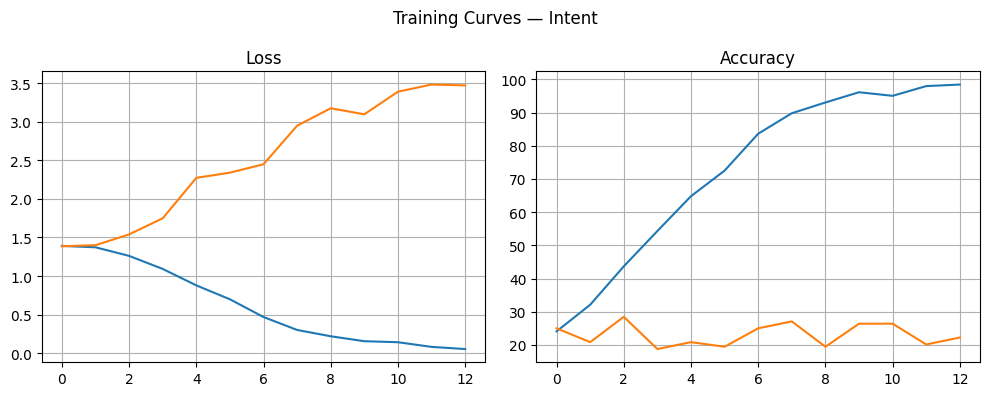

Saved -> best_intent_model.pth


In [16]:
# Curves
plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.plot(hist['train_loss']); plt.plot(hist['val_loss']); plt.title('Loss'); plt.grid(True)
plt.subplot(1,2,2); plt.plot(hist['train_acc']);  plt.plot(hist['val_acc']);  plt.title('Accuracy'); plt.grid(True)
plt.suptitle('Training Curves — Intent'); plt.tight_layout(); plt.show()

print('Saved ->', CKPT)